In [148]:
from sklearn import model_selection, linear_model, metrics
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [149]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузка исходных данных

Тренировочные данные

In [150]:
train_data = pd.read_csv('train_titanic.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Тестовые данные

In [151]:
test_data = pd.read_csv('test_titanic.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Описание признаков

1.  PassangerId - идентификационный номер пассажира или члена экипажа
2.  Pclass      - класс каюты (значения: 1, 2, 3)
3.  Name        - имя пассажира или члена экипажа
4.  Sex         - пол (значения: male, female)
5.  Age         - возраст пассажира или члена экипажа
6.  SibSp       - родственные отношения (брат, сестра, сводный брат, сводная сестра)
7.  Parch       - родственные отношения (мать, отец, дочь, сын, приёмная дочь, приёмный сын), 0 - ребёнок с няней
8.  Ticket      - номер билета
9.  Fare        - стоимость билета
10. Cabin       - номер каюты
11. Embarked    - пункт отправления пассажира (значения: C-Cherbourg, Q-Queenstown, S-Southampton)

# Анализ пропущенных данных

Объединим тестовые и тренировочные данные

In [152]:
all_data = pd.concat([train_data, test_data], ignore_index=True)

In [153]:
# Размеры данных
print('Размер тренировочных данных:\t', train_data.shape, '\n')
print('Размер тестовых данных:\t\t', test_data.shape, '\n')
print('Размер объединенных данных:\t', all_data.shape, '\n')

Размер тренировочных данных:	 (891, 12) 

Размер тестовых данных:		 (418, 11) 

Размер объединенных данных:	 (1309, 12) 



In [154]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [155]:
print('Количество пропущенных данных:')
all_data.isnull().sum()

Количество пропущенных данных:


Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

# Исследование зависимости выживаемости от возраста

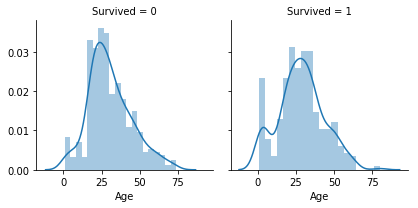

In [156]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(sns.distplot, 'Age', bins=20)
#age_surve.head()

# Исследование зависимости класса каюты от возраста

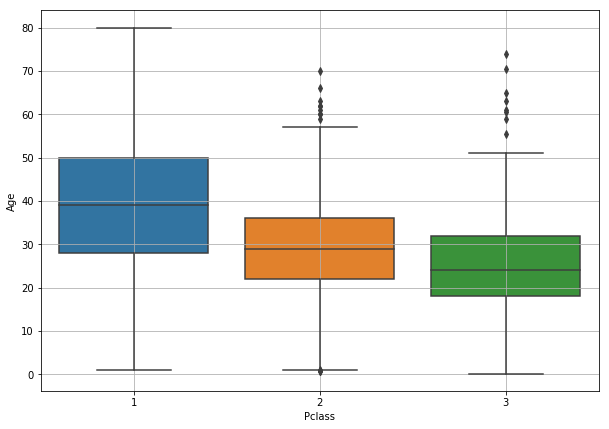

In [157]:
plt.figure(figsize=(10, 7))
sns.boxplot(x=all_data['Pclass'], y=all_data['Age'])
plt.grid()

# Расчитаем средний возраст пассажиров для каждого из классов

In [158]:
age_by_pclass_sex = all_data.groupby(['Sex', 'Pclass']).median()

In [159]:
age_by_pclass_sex

Age      Fare  Parch  PassengerId  SibSp  Survived
Sex    Pclass                                                     
female 1       36.0  80.92915      0          710      0       1.0
       2       28.0  23.00000      0          589      0       1.0
       3       22.0  10.48960      0          637      0       0.5
male   1       42.0  49.50420      0          648      0       0.0
       2       29.5  13.00000      0          715      0       0.0
       3       25.0   7.89580      0          649      0       0.0

# Заменим пропущенные значения возраста средними по классу

In [160]:
all_data['Age'] = all_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

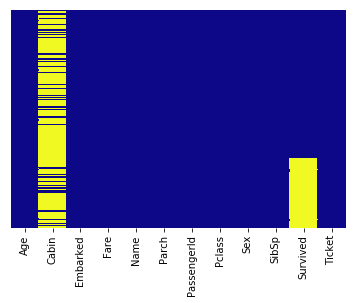

In [161]:
sns.heatmap(all_data.isna(),yticklabels=False,cbar=False, cmap='plasma')

# Удалим признак Cabin - пропущено 90%

In [162]:
all_data.drop(labels='Cabin', axis=1, inplace=True)

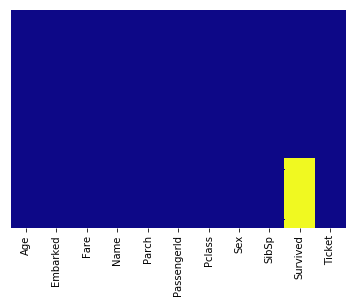

In [163]:
sns.heatmap(all_data.isna(), yticklabels=False, cbar=False, cmap='plasma')

In [164]:
print('Количество пропущенных данных:')
all_data.isnull().sum()

Количество пропущенных данных:


Age              0
Embarked         2
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

# Замена пропущенных признаков Embarked на самый популярный

In [165]:
from statistics import mode
#Проверим самый частый элемент
most_freq_in_Embarked = mode(all_data['Embarked'])
print(most_freq_in_Embarked)

S


In [166]:
all_data['Embarked'] = all_data['Embarked'].fillna(most_freq_in_Embarked)
all_data.isnull().sum()

Age              0
Embarked         0
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

In [167]:
np.nonzero(all_data['Fare']==0)[0]
all_data['Fare'][179]

0.0

# Анализ стоимости билета (Fare)

In [168]:
fare_pclass = all_data.groupby(['Pclass']).median()['Fare']

In [169]:
fare_pclass

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64

# Замена пропущенного значения Fare медианным

In [170]:
all_data['Fare'] = all_data.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))

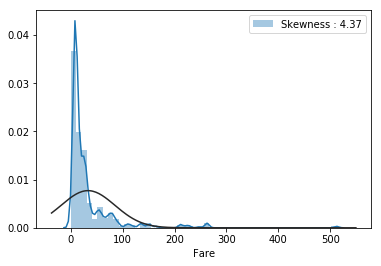

In [171]:
from scipy import stats
from scipy.stats import norm

g = sns.distplot(all_data['Fare'], fit=norm, label="Skewness : %.2f"%(all_data["Fare"].skew()))
g = g.legend()

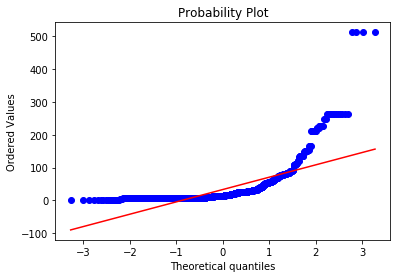

In [172]:
res = stats.probplot(all_data['Fare'], plot=plt)

# Сделаем логарифмическое преобразование признака Fare

In [207]:
all_data['Fare'] = np.floor(np.log1p(all_data['Fare']))

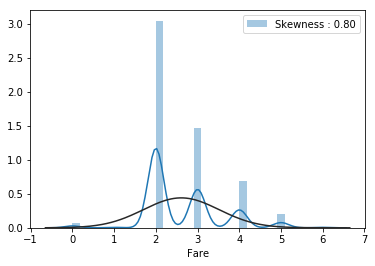

In [174]:
g = sns.distplot(all_data['Fare'], fit=norm, label="Skewness : %.2f"%(all_data["Fare"].skew()))
g = g.legend()

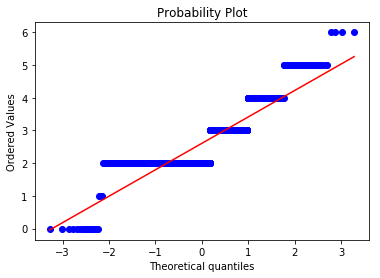

In [175]:
res = stats.probplot(all_data['Fare'], plot=plt)

In [186]:
uniq_el_in_fare = len(np.unique(all_data['Fare']))
print('уникальных элементов в Fare:', uniq_el_in_fare)

уникальных элементов в Fare: 7


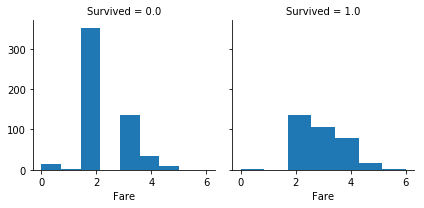

In [201]:
g = sns.FacetGrid(data = all_data, col='Survived')
g.map(plt.hist, 'Fare', bins=uniq_el_in_fare)